# Import necessary libraries

In [1]:
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
os.chdir("..")

# Prepare Data

In [2]:
str_col = ['reference', 'translation']
num_col = ['ref_tox', 'trn_tox', 'similarity', 'lenght_diff']

data = pd.read_csv("data/interim/preprocessed_filtered_1.tsv", sep='\t', index_col=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577777 entries, 0 to 577776
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   reference    577777 non-null  object 
 1   translation  577777 non-null  object 
 2   ref_tox      577777 non-null  float64
 3   trn_tox      577777 non-null  float64
 4   similarity   577777 non-null  float64
 5   length_diff  577777 non-null  float64
dtypes: float64(4), object(2)
memory usage: 30.9+ MB


# Prepare Dataloader

In [4]:
from src.data.make_dataset import prepareData, get_dataloader, tensorFromSentence

# Define models

In [5]:
from src.models.transformer import Transformer, Encoder, Decoder

# Train model

In [6]:
from src.models.train_model import train

In [7]:
epochs = 7
embed_size = 512
n_layer = 6
n_head = 6
hidden_size = 512
batch_size = 128
lr = 5e-5
MAX_LENGTH = 32
model_path = "transformer.pt"
start_epoch = 13

vocab_tox, vocab_detox, pairs = prepareData(data, MAX_LENGTH)
train_dataloader, val_dataloader = get_dataloader(batch_size, vocab_tox, vocab_detox, pairs, MAX_LENGTH, device=device)

Counted words:
tox-vocab 61284
detox-vocab 56454


In [8]:
encoder = Encoder(vocab_tox.n_words, n_layer, n_head, batch_size, embed_size, hidden_size, vocab_tox, device=device, max_length=MAX_LENGTH)
decoder = Decoder(n_layer, n_head, batch_size, embed_size, hidden_size, vocab_detox.n_words, vocab_detox, device=device, max_length=MAX_LENGTH)
model = Transformer(encoder, decoder).to(device)

if start_epoch != 1: # Continue the existing training
    model = torch.load(model_path)

print(sum(p.numel() for p in model.parameters())/1e6, 'Million parameters')

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_detox.word2index['<pad>'])

loss_train, loss_val = train(
    model, 
    train_dataloader, 
    val_dataloader, 
    optimizer=optimizer, 
    criterion=criterion, 
    start_epoch=start_epoch,
    epochs=epochs, 
    lr=lr, 
    model_path=model_path
)

145.917062 Million parameters


Epoch 19: val: 100%|██████████| 431/431 [00:47<00:00,  9.05it/s, loss=2.11]


# Plot loss

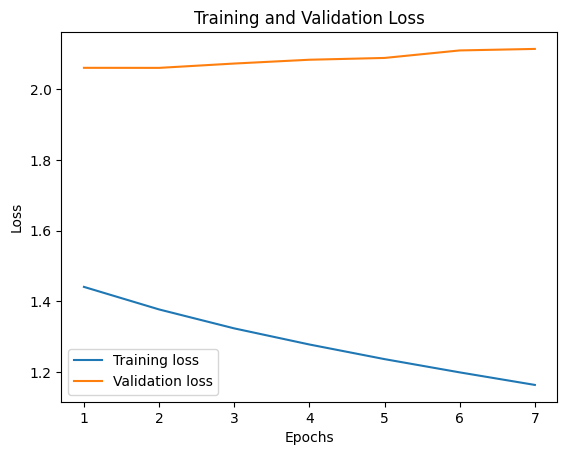

In [9]:
plt.plot(range(1, epochs + 1), loss_train, label='Training loss')
plt.plot(range(1, epochs + 1), loss_val, label='Validation loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

# Check in random sample from dataset

In [10]:
def evaluate(model, sentence, vocab_tox, vocab_detox):
    with torch.no_grad():
        model.eval()
        input_tensor = tensorFromSentence(vocab_tox, sentence, device=device)
        outputs = model.generate_beam(input_tensor, max_length=model.decoder.max_length)

        ids = outputs.squeeze()
        
        words = []
        for idx in ids:
            if idx.item() == vocab_detox.word2index['<eos>']:
                break
            words.append(vocab_detox.index2word[idx.item()])
    return words

In [11]:
import random
import string

def evaluateRandomly(model, vocab_tox, vocab_detox, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('origin:     ', pair[0])
        print('translated: ', pair[1])
        output_words = evaluate(model, pair[0], vocab_tox, vocab_detox)
        output_sentence = "".join([" "+i if not i.startswith("'") and not i.startswith("n'") and i not in string.punctuation else i for i in output_words]).strip()
        print('predicted:  ', output_sentence)
        print('')

In [33]:
load_model = torch.load(model_path)

load_model.eval()
evaluateRandomly(load_model, vocab_tox, vocab_detox)

origin:      the boys have a straw bigger than these sausages !
translated:  those kids ' dicksare bigger than them sausages !
predicted:   <sos> have boys bigger dicks than these sausages!

origin:      i asked you something , he said .
translated:  i asked you a damn question , he said .
predicted:   <sos> fucking asked you some shit, he said.

origin:      i think it was a century of writing .
translated:  i think she is the fuck of the century .
predicted:   <sos> i think it was a century of fucking writing.

origin:      you should write this down .
translated:  and , uh you should write this shit down .
predicted:   <sos> you should write this shit down.

origin:      the little sod was in paradise .
translated:  that little sucker was in heaven .
predicted:   <sos> the little fool was in paradise.

origin:      would it hurt to say thank you ?
translated:  would it kill him if he said thank you ?
predicted:   <sos> would it fucking hurt to say thank you?

origin:      what in th